In [49]:
import matplotlib.pyplot as plt
import networkx as nx
from nltk import sent_tokenize
from nltk import word_tokenize
import numpy as np
import re
import pickle
import string
import operator
import itertools
import community
import json
import statistics
from collections import Counter

## Descripción de los grafos por año
### Los grafos están construidos utilizando únicamente sustantivos (comunes y propios) y con co-ocurrencia dentro de una oración. Se utilizaron 2080 introducciones de la revista Cell.

### cell

In [51]:
keys_doi=['2010','2011','2012','2013','2014','2015','2016']

In [52]:
graphs_cell = pickle.load(open( 'graphs_cell.p', 'rb' ) )

In [53]:
for key in keys_doi:
    G=graphs_cell[key]
    print(key)
    print('nodes: '+str(len(G.nodes)))
    print('edges: '+str(len(G.edges)))
    print('average degree: '+str(sum(dict(nx.degree(G,weight='weight')).values())/float(len(G.nodes))))
    print('max degree: '+str(max(dict(nx.degree(G,weight='weight')).values())))
    core_number=nx.core_number(G)
    print('max core number: '+str(max(core_number.values())))
    main_core=nx.k_core(G,max(core_number.values()))
    print('main core size: '+str(len(main_core)))
    main_crust=nx.k_crust(G,max(core_number.values())-1)
    print('main crust size: '+str(len(main_crust)))

2010
nodes: 2851
edges: 19781
average degree: 13.876534549280954
max degree: 242
max core number: 14
main core size: 207
main crust size: 2644
2011
nodes: 3333
edges: 24065
average degree: 14.44044404440444
max degree: 312
max core number: 16
main core size: 124
main crust size: 3209
2012
nodes: 4145
edges: 31110
average degree: 15.010856453558505
max degree: 375
max core number: 18
main core size: 236
main crust size: 3909
2013
nodes: 3917
edges: 28879
average degree: 14.745468470768445
max degree: 383
max core number: 17
main core size: 222
main crust size: 3695
2014
nodes: 3927
edges: 30284
average degree: 15.423478482302011
max degree: 305
max core number: 18
main core size: 294
main crust size: 3633
2015
nodes: 4144
edges: 33662
average degree: 16.246138996138995
max degree: 422
max core number: 20
main core size: 180
main crust size: 3964
2016
nodes: 3754
edges: 28014
average degree: 14.924880127863613
max degree: 318
max core number: 18
main core size: 131
main crust size: 3623


## core number

In [108]:
core_number={}
for key in keys_doi:
    core_number[key]=nx.core_number(graphs_cell[key])

In [109]:
for key in keys_doi:
    core_number[key]={x:round(core_number[key][x]/float(max(list(core_number[key].values()))),1) for x in core_number[key].keys()}

In [110]:
core_number_evol={x:[] for x in core_number['2010'].keys()}
for x in core_number['2010'].keys():
    for key in keys_doi:
        if x in core_number[key].keys():
            core_number_evol[x]+=[core_number[key][x]]
        else:
            core_number_evol[x]+=[0]

In [111]:
core_number_evol

{'fiber': [0.6, 0.5, 0.4, 1.0, 0.8, 1.0, 0.8],
 'muscle': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7],
 'myoblast': [0.6, 0, 0.6, 0.2, 0, 0, 0],
 'satellite': [0.3, 0.7, 0, 0.8, 0, 0, 0.3],
 'myogenesis': [0.4, 0.4, 0, 0, 0, 0, 0],
 'e11': [0.1, 0, 0, 0, 0, 0, 0],
 'wave': [0.4, 0, 0.7, 0.8, 0.4, 0.7, 0.5],
 'e145': [0.4, 0, 0, 0, 0, 0, 0],
 'e175': [0.4, 0, 0, 0, 0, 0, 0],
 'e16': [0.2, 0, 0, 0, 0, 0, 0],
 'myotube': [0.1, 0.5, 0.2, 0, 0, 0, 0],
 'myhcs': [0.1, 0, 0, 0, 0, 0, 0],
 'myhc': [0.4, 0, 0, 0, 0, 0, 0],
 'enolase': [0.4, 0, 0, 0, 0, 0, 0],
 'mck': [0.4, 0, 0, 0, 0.2, 0, 0],
 'pkc': [0.4, 0.2, 0.3, 0, 0.3, 0.4, 0],
 'fetus': [0.1, 0, 0.3, 0.3, 0, 0, 0.6],
 'gene': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'nfib': [0.4, 0, 0, 0, 0.3, 0, 0.2],
 'amniote': [0.4, 0, 0, 0, 0, 0, 0],
 'nfix': [0.4, 0, 0, 0, 0, 0, 0],
 'nfic': [0.4, 0, 0, 0, 0, 0, 0],
 'nfia': [0.6, 0, 0, 0, 0, 0, 0],
 'n3tgccapu3': [0.1, 0, 0, 0, 0, 0, 0],
 'affinity': [0.9, 0.2, 0.9, 1.0, 0.9, 0.9, 1.0],
 'nfi': [0.5, 0, 0, 0

In [112]:
for x in core_number_evol.keys():
    core_number_evol[x]=[core_number_evol[x][0],core_number_evol[x][-1]]#np.mean(core_number_evol[x][0:]),np.std(core_number_evol[x][0:])]

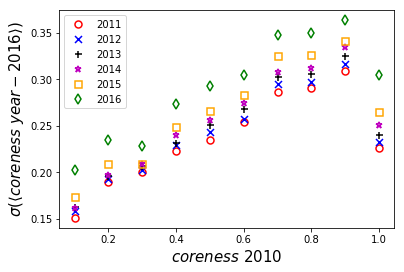

In [113]:
#data=list(core_number_evol.values())
markers=[['r','o'],['b','x'],['k','+'],['m','*'],['orange','s'],['green','d']]
for j in [1,2,3,4,5,6]:
    core_number_evol={x:[] for x in core_number['2010'].keys()}
    for x in core_number['2010'].keys():
        for key in keys_doi:
            if x in core_number[key].keys():
                core_number_evol[x]+=[core_number[key][x]]
            else:
                core_number_evol[x]+=[0]
    for x in core_number_evol.keys():
        core_number_evol[x]=[core_number_evol[x][0],np.mean(core_number_evol[x][j:])]
    data=list(core_number_evol.values())
    X=list(zip(*data))[0]
    Y=list(zip(*data))[1]

    X_reduced=list(set(X))
    Y_dict={x:[] for x in X_reduced}
    for x in X_reduced:
        for i in range(len(X)):
            if X[i]==x:
                Y_dict[x]+=[Y[i]]
    for x in X_reduced:
        Y_dict[x]=np.std(Y_dict[x])
    
    plt.plot(X_reduced,Y_dict.values(),color=markers[j-1][0],marker=markers[j-1][1],markersize=7,fillstyle='none',markeredgewidth=1.5,clip_on=False,linewidth=0.,label=keys_doi[j])
plt.legend(loc='best')

plt.ylabel(r'$\sigma(\langle coreness \ year-2016\rangle)$',fontsize=15)
plt.xlabel(r'$coreness \ 2010$',fontsize=15)
plt.rcParams.update({'font.size': 10})
#plt.savefig('MC_size.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

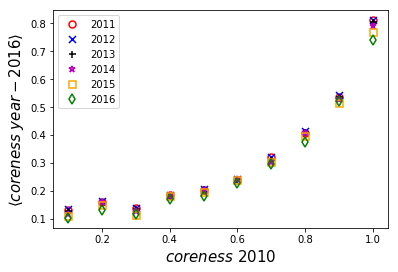

In [114]:
#data=list(core_number_evol.values())
markers=[['r','o'],['b','x'],['k','+'],['m','*'],['orange','s'],['green','d']]
for j in [1,2,3,4,5,6]:
    core_number_evol={x:[] for x in core_number['2010'].keys()}
    for x in core_number['2010'].keys():
        for key in keys_doi:
            if x in core_number[key].keys():
                core_number_evol[x]+=[core_number[key][x]]
            else:
                core_number_evol[x]+=[0]
    for x in core_number_evol.keys():
        core_number_evol[x]=[core_number_evol[x][0],np.mean(core_number_evol[x][j:])]
    data=list(core_number_evol.values())
    X=list(zip(*data))[0]
    Y=list(zip(*data))[1]

    X_reduced=list(set(X))
    Y_dict={x:[] for x in X_reduced}
    for x in X_reduced:
        for i in range(len(X)):
            if X[i]==x:
                Y_dict[x]+=[Y[i]]
    for x in X_reduced:
        Y_dict[x]=np.mean(Y_dict[x])
    
    plt.plot(X_reduced,Y_dict.values(),color=markers[j-1][0],marker=markers[j-1][1],markersize=7,fillstyle='none',markeredgewidth=1.5,clip_on=False,linewidth=0.,label=keys_doi[j])
plt.legend(loc='best')

plt.ylabel(r'$\langle coreness \ year-2016\rangle$',fontsize=15)
plt.xlabel(r'$coreness \ 2010$',fontsize=15)
plt.rcParams.update({'font.size': 10})
#plt.savefig('MC_size.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

## core number vs clustering

In [134]:
core_number={}
for key in keys_doi:
    if key=='2010':
        core_number[key]=nx.clustering(graphs_cell[key])
    else:
        core_number[key]=nx.core_number(graphs_cell[key])

In [135]:
for key in keys_doi:
    core_number[key]={x:round(core_number[key][x]/float(max(list(core_number[key].values()))),1) for x in core_number[key].keys()}

In [136]:
core_number_evol={x:[] for x in core_number['2010'].keys()}
for x in core_number['2010'].keys():
    for key in keys_doi:
        if x in core_number[key].keys():
            core_number_evol[x]+=[core_number[key][x]]
        else:
            core_number_evol[x]+=[0]

In [137]:
for x in core_number_evol.keys():
    core_number_evol[x]=[core_number_evol[x][0],core_number_evol[x][-1]]#np.mean(core_number_evol[x][0:]),np.std(core_number_evol[x][0:])]

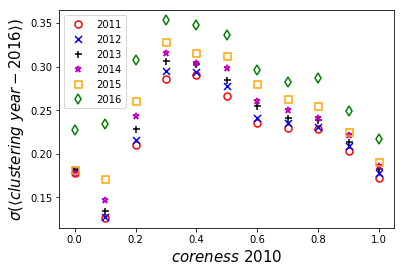

In [138]:
#data=list(core_number_evol.values())
markers=[['r','o'],['b','x'],['k','+'],['m','*'],['orange','s'],['green','d']]
for j in [1,2,3,4,5,6]:
    core_number_evol={x:[] for x in core_number['2010'].keys()}
    for x in core_number['2010'].keys():
        for key in keys_doi:
            if x in core_number[key].keys():
                core_number_evol[x]+=[core_number[key][x]]
            else:
                core_number_evol[x]+=[0]
    for x in core_number_evol.keys():
        core_number_evol[x]=[core_number_evol[x][0],np.mean(core_number_evol[x][j:])]
    data=list(core_number_evol.values())
    X=list(zip(*data))[0]
    Y=list(zip(*data))[1]

    X_reduced=list(set(X))
    Y_dict={x:[] for x in X_reduced}
    for x in X_reduced:
        for i in range(len(X)):
            if X[i]==x:
                Y_dict[x]+=[Y[i]]
    for x in X_reduced:
        Y_dict[x]=np.std(Y_dict[x])
    
    plt.plot(X_reduced,Y_dict.values(),color=markers[j-1][0],marker=markers[j-1][1],markersize=7,fillstyle='none',markeredgewidth=1.5,clip_on=False,linewidth=0.,label=keys_doi[j])
plt.legend(loc='best')

plt.ylabel(r'$\sigma(\langle clustering \ year-2016\rangle)$',fontsize=15)
plt.xlabel(r'$coreness \ 2010$',fontsize=15)
plt.rcParams.update({'font.size': 10})
#plt.savefig('MC_size.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

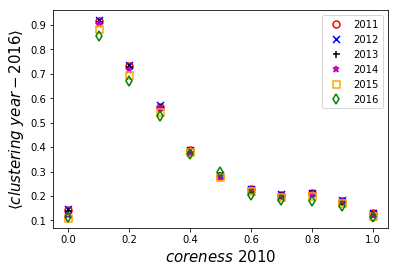

In [139]:
#data=list(core_number_evol.values())
markers=[['r','o'],['b','x'],['k','+'],['m','*'],['orange','s'],['green','d']]
for j in [1,2,3,4,5,6]:
    core_number_evol={x:[] for x in core_number['2010'].keys()}
    for x in core_number['2010'].keys():
        for key in keys_doi:
            if x in core_number[key].keys():
                core_number_evol[x]+=[core_number[key][x]]
            else:
                core_number_evol[x]+=[0]
    for x in core_number_evol.keys():
        core_number_evol[x]=[core_number_evol[x][0],np.mean(core_number_evol[x][j:])]
    data=list(core_number_evol.values())
    X=list(zip(*data))[0]
    Y=list(zip(*data))[1]

    X_reduced=list(set(X))
    Y_dict={x:[] for x in X_reduced}
    for x in X_reduced:
        for i in range(len(X)):
            if X[i]==x:
                Y_dict[x]+=[Y[i]]
    for x in X_reduced:
        Y_dict[x]=np.mean(Y_dict[x])
    
    plt.plot(X_reduced,Y_dict.values(),color=markers[j-1][0],marker=markers[j-1][1],markersize=7,fillstyle='none',markeredgewidth=1.5,clip_on=False,linewidth=0.,label=keys_doi[j])
plt.legend(loc='best')

plt.ylabel(r'$\langle clustering \ year-2016\rangle$',fontsize=15)
plt.xlabel(r'$coreness \ 2010$',fontsize=15)
plt.rcParams.update({'font.size': 10})
#plt.savefig('MC_size.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()